<h1 align='center' style='color:blue'>Credit Risk Modeling Project</h1>

In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import optuna

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import uniform, randint
from joblib import dump

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.metrics import make_scorer, f1_score, roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
np.set_printoptions(suppress=True)

In [113]:
# File paths
customer_data_path = r"D:\ML\Classification\Credit_Risk_Modelling\data\customers.csv"
loans_data_path = r"D:\ML\Classification\Credit_Risk_Modelling\data\loans.csv"
bureau_data_path = r"D:\ML\Classification\Credit_Risk_Modelling\data\bureau_data.csv"

# Load data
data_customers = pd.read_csv(customer_data_path)
data_loans = pd.read_csv(loans_data_path)
data_bureau = pd.read_csv(bureau_data_path)

# Print success message
print("All data loaded successfully")

All data loaded successfully


In [114]:
print(f"Customers Data Shape: {data_customers.shape} (Rows, Columns)")
print(f"Loans Data Shape: {data_loans.shape} (Rows, Columns)")
print(f"Bureau Data Shape: {data_bureau.shape} (Rows, Columns)")

Customers Data Shape: (50000, 12) (Rows, Columns)
Loans Data Shape: (50000, 15) (Rows, Columns)
Bureau Data Shape: (50000, 8) (Rows, Columns)


In [115]:
data_bureau

,cust_id,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio
0,C00001,1,1,42,0,0,3,7
1,C00002,3,1,96,12,60,5,4
2,C00003,2,1,82,24,147,6,58
3,C00004,3,0,115,15,87,5,26
4,C00005,4,2,120,0,0,5,10
...,...,...,...,...,...,...,...,...
49995,C49996,4,2,165,1,6,8,24
49996,C49997,4,0,161,0,0,4,91
49997,C49998,4,1,42,0,0,7,38
49998,C49999,1,2,42,9,47,4,17


In [116]:
df = pd.merge(data_customers, data_loans, on="cust_id")
df.head(3)

,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,state,zipcode,loan_id,loan_purpose,loan_type,sanction_amount,loan_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,disbursal_date,installment_start_dt,default
0,C00001,44,M,Married,Self-Employed,2586000,3,Owned,27,Delhi,Delhi,110001,L00001,Auto,Secured,3004000,2467000,49340.00,444060,1973600,33,1630408,873386,2019-07-24,2019-08-10,False
1,C00002,38,M,Married,Salaried,1206000,3,Owned,4,Chennai,Tamil Nadu,600001,L00002,Home,Secured,4161000,3883000,77660.00,698940,3106400,30,709309,464100,2019-07-24,2019-08-15,False
2,C00003,46,F,Married,Self-Employed,2878000,3,Owned,24,Kolkata,West Bengal,700001,L00003,Personal,Unsecured,2401000,2170000,43400.00,390600,1736000,21,1562399,1476042,2019-07-24,2019-08-21,False


In [117]:
data = pd.merge(df, data_bureau, on="cust_id")
data.head(3)

,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,state,zipcode,loan_id,loan_purpose,loan_type,sanction_amount,loan_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,disbursal_date,installment_start_dt,default,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio
0,C00001,44,M,Married,Self-Employed,2586000,3,Owned,27,Delhi,Delhi,110001,L00001,Auto,Secured,3004000,2467000,49340.00,444060,1973600,33,1630408,873386,2019-07-24,2019-08-10,False,1,1,42,0,0,3,7
1,C00002,38,M,Married,Salaried,1206000,3,Owned,4,Chennai,Tamil Nadu,600001,L00002,Home,Secured,4161000,3883000,77660.00,698940,3106400,30,709309,464100,2019-07-24,2019-08-15,False,3,1,96,12,60,5,4
2,C00003,46,F,Married,Self-Employed,2878000,3,Owned,24,Kolkata,West Bengal,700001,L00003,Personal,Unsecured,2401000,2170000,43400.00,390600,1736000,21,1562399,1476042,2019-07-24,2019-08-21,False,2,1,82,24,147,6,58


In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cust_id                      50000 non-null  object 
 1   age                          50000 non-null  int64  
 2   gender                       50000 non-null  object 
 3   marital_status               50000 non-null  object 
 4   employment_status            50000 non-null  object 
 5   income                       50000 non-null  int64  
 6   number_of_dependants         50000 non-null  int64  
 7   residence_type               49938 non-null  object 
 8   years_at_current_address     50000 non-null  int64  
 9   city                         50000 non-null  object 
 10  state                        50000 non-null  object 
 11  zipcode                      50000 non-null  int64  
 12  loan_id                      50000 non-null  object 
 13  loan_purpose    

In [119]:
data["default"] = data["default"].astype(int)
data["default"].value_counts()

default
0    45703
1     4297
Name: count, dtype: int64

- default is a target variable and we can see some class imbalance here.

**Train Test split**

- We perform train test split before doing EDA to prevent data leakage. We don't want test set (which is part of the entire dataset) to influence EDA or any decisions on feature engineering. 

In [120]:
X = data.drop("default", axis="columns")
y = data["default"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

data_train = pd.concat([X_train, y_train], axis="columns")
data_test = pd.concat([X_test, y_test], axis="columns")

print(f"Training Data Shape: {data_train.shape} (Rows, Columns)")
print(f"Testing Data Shape: {data_test.shape} (Rows, Columns)")

Training Data Shape: (37500, 33) (Rows, Columns)
Testing Data Shape: (12500, 33) (Rows, Columns)


<h3 align="center" style="color:blue">Data Cleaning</h3>

**Handle Missing & Duplicate Values**

In [121]:
data_train.isnull().sum()

cust_id                         0
age                             0
gender                          0
marital_status                  0
employment_status               0
income                          0
number_of_dependants            0
residence_type                 47
years_at_current_address        0
city                            0
state                           0
zipcode                         0
loan_id                         0
loan_purpose                    0
loan_type                       0
sanction_amount                 0
loan_amount                     0
processing_fee                  0
gst                             0
net_disbursement                0
loan_tenure_months              0
principal_outstanding           0
bank_balance_at_application     0
disbursal_date                  0
installment_start_dt            0
number_of_open_accounts         0
number_of_closed_accounts       0
total_loan_months               0
delinquent_months               0
total_dpd     

In [122]:
# Print unique values of 'residence_type' column before handling missing values
print(f"Unique residence types before filling missing values: {data_train['residence_type'].unique()}")

# Calculate and print the mode of 'residence_type'
mode_residence = data_train["residence_type"].mode()[0]
print(f"Mode of residence_type: {mode_residence}")

# Fill missing values with the mode
data_train["residence_type"].fillna(mode_residence, inplace=True)

# Print unique values of 'residence_type' column after handling missing values
print(f"Unique residence types after filling missing values: {data_train['residence_type'].unique()}")


Unique residence types before filling missing values: ['Owned' 'Mortgage' 'Rented' nan]
Mode of residence_type: Owned
Unique residence types after filling missing values: ['Owned' 'Mortgage' 'Rented']


C:\Users\rohit\AppData\Local\Temp\ipykernel_12852\1651501032.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_train["residence_type"].fillna(mode_residence, inplace=True)


In [123]:
data_test["residence_type"].fillna(mode_residence, inplace=True)

print("Missing values in 'residence_type' column of data_test filled with the mode_residence.")

Missing values in 'residence_type' column of data_test filled with the mode_residence.


C:\Users\rohit\AppData\Local\Temp\ipykernel_12852\3339748258.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_test["residence_type"].fillna(mode_residence, inplace=True)


In [124]:
data_train.duplicated().sum()

0

In [125]:
data_train.columns

Index(['cust_id', 'age', 'gender', 'marital_status', 'employment_status',
       'income', 'number_of_dependants', 'residence_type',
       'years_at_current_address', 'city', 'state', 'zipcode', 'loan_id',
       'loan_purpose', 'loan_type', 'sanction_amount', 'loan_amount',
       'processing_fee', 'gst', 'net_disbursement', 'loan_tenure_months',
       'principal_outstanding', 'bank_balance_at_application',
       'disbursal_date', 'installment_start_dt', 'number_of_open_accounts',
       'number_of_closed_accounts', 'total_loan_months', 'delinquent_months',
       'total_dpd', 'enquiry_count', 'credit_utilization_ratio', 'default'],
      dtype='object')

In [126]:
columns_continuous = ['age', 'income', 'number_of_dependants', 'years_at_current_address', 
                      'sanction_amount', 'loan_amount', 'processing_fee', 'gst', 'net_disbursement', 
                      'loan_tenure_months','principal_outstanding', 'bank_balance_at_application',
                      'number_of_open_accounts','number_of_closed_accounts', 'total_loan_months', 'delinquent_months',
                       'total_dpd', 'enquiry_count', 'credit_utilization_ratio']

columns_categorical = ['gender', 'marital_status', 'employment_status', 'residence_type', 'city', 
                       'state', 'zipcode', 'loan_purpose', 'loan_type', 'default']

### Box plot to visualize outliers

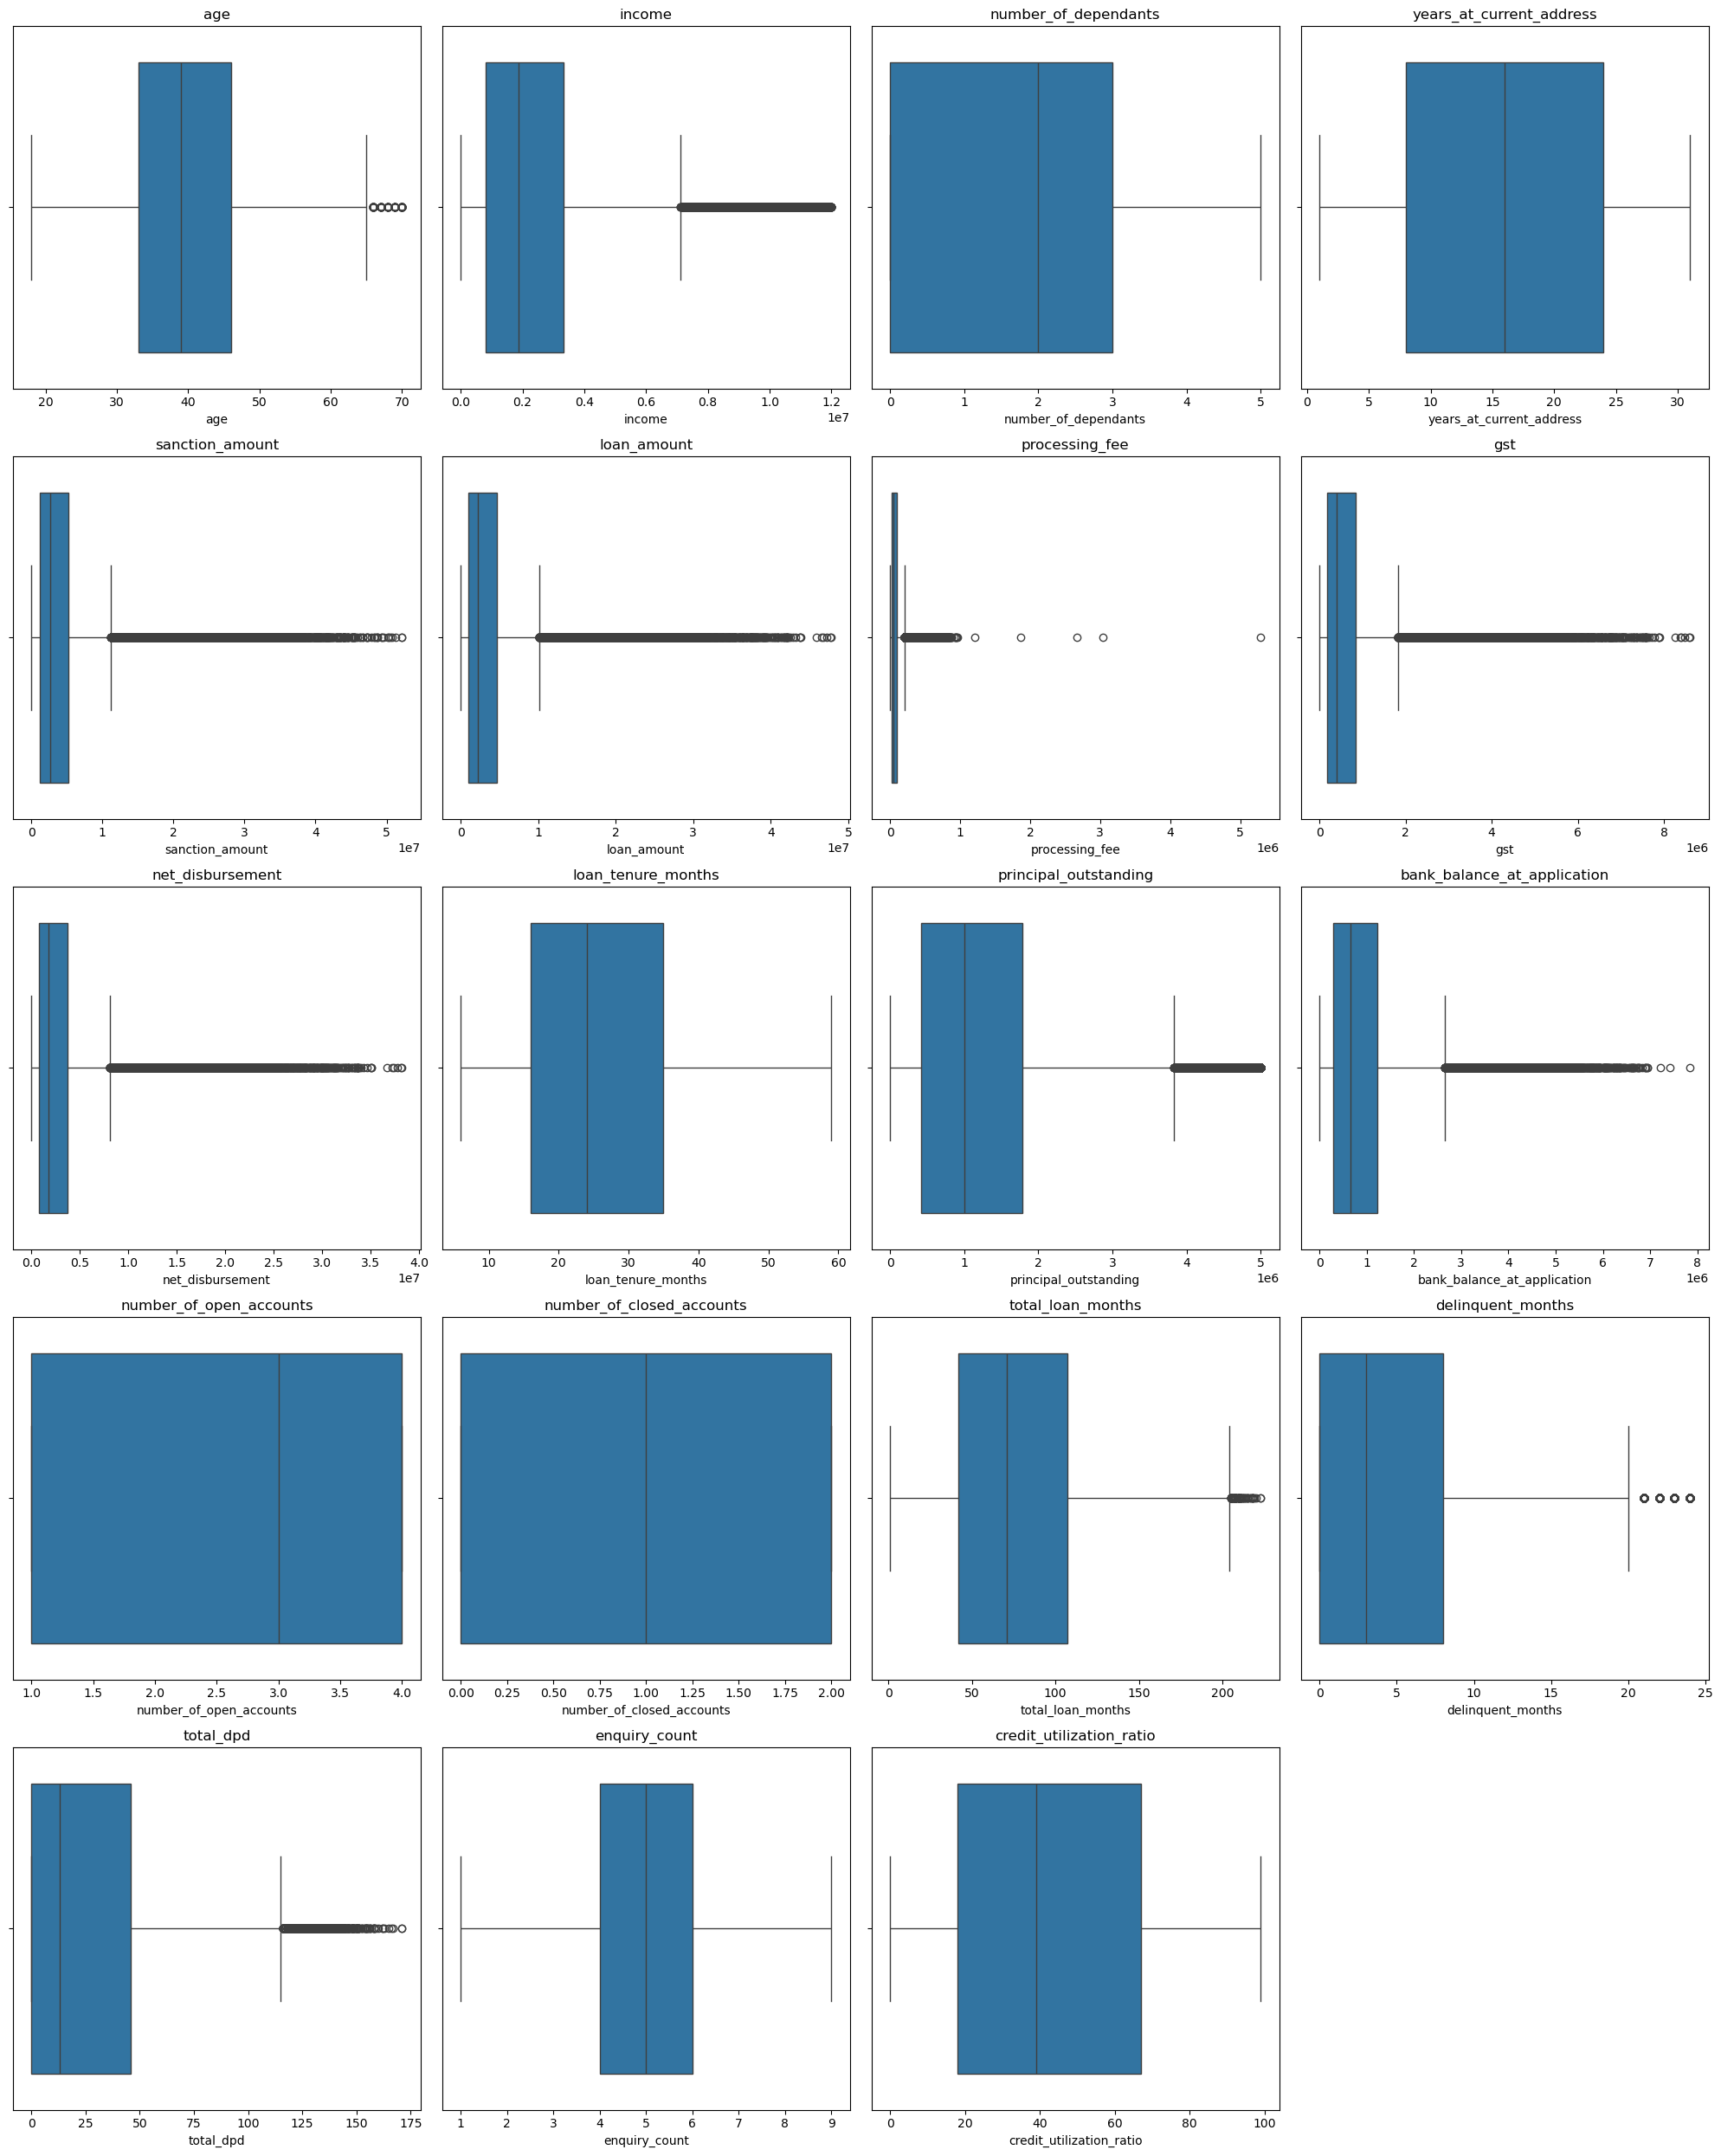

In [127]:
num_plots = len(columns_continuous)
num_cols = 4  # Number of plots per row
num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, col in enumerate(columns_continuous):
    sns.boxplot(x=data_train[col], ax=axes[i])
    axes[i].set_title(col)  # Set the title to the name of the variable

# If there are any empty plots (if the number of plots isn't a perfect multiple of num_cols), hide the axes
for j in range(i + 1, num_rows * num_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

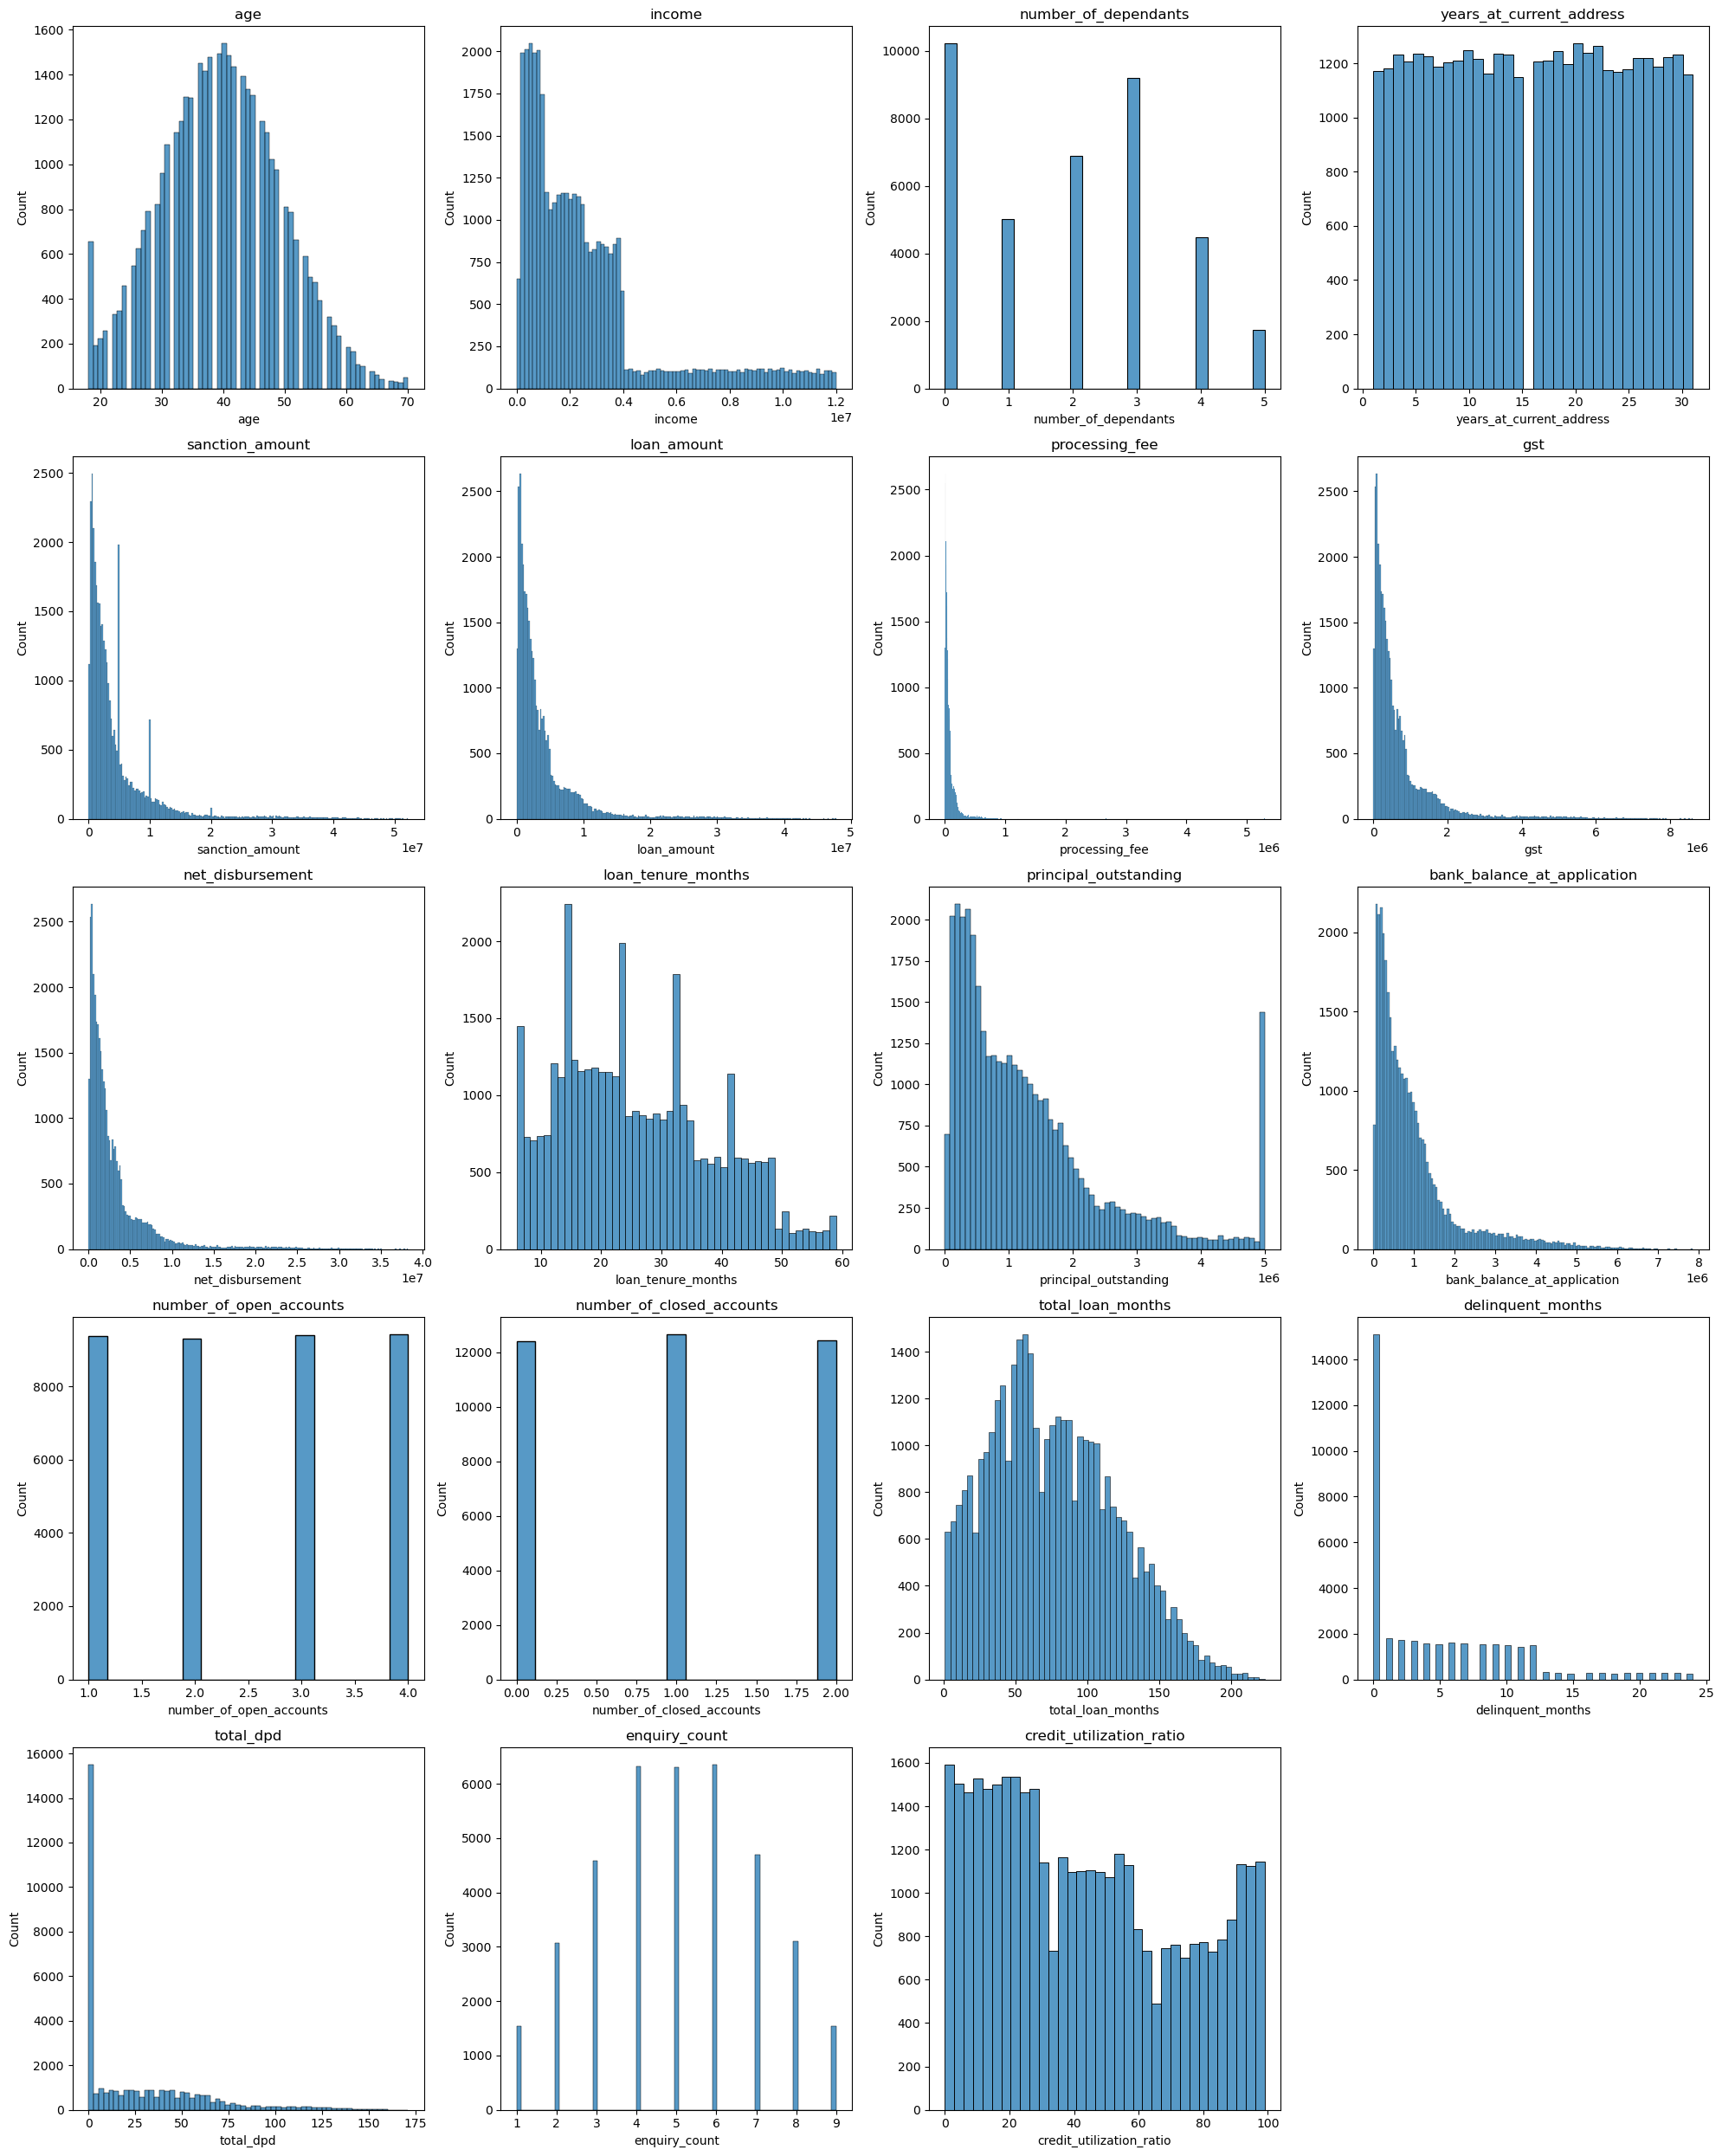

In [128]:
num_plots = len(columns_continuous)
num_cols = 4  # Number of plots per row
num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, col in enumerate(columns_continuous):
    sns.histplot(data_train[col], ax=axes[i])
    axes[i].set_title(col)  # Set the title to the name of the variable

# If there are any empty plots (if the number of plots isn't a perfect multiple of num_cols), hide the axes
for j in range(i + 1, num_rows * num_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Outlier Removal: Processing Fee

In [129]:
data_train["processing_fee"].describe()

count     37500.00
mean      80290.68
std      113128.14
min           0.00
25%       19220.00
50%       44600.00
75%       92420.00
max     5293543.52
Name: processing_fee, dtype: float64

In [130]:
data_train[data_train["processing_fee"] == data_train["processing_fee"].max()][["income", "loan_amount", "processing_fee"]]

,income,loan_amount,processing_fee
9898,8948000,3626000,5293543.52


In [131]:
data_train[data_train["processing_fee"] > data_train["loan_amount"]][["income", "loan_amount", "processing_fee"]]

,income,loan_amount,processing_fee
23981,1790000,2234000,2669791.02
28174,1123000,966000,1214492.67
47089,1892000,1738000,1858964.77
29305,3839000,2616000,3036378.01
9898,8948000,3626000,5293543.52


In [132]:
data_train_1 = data_train[data_train["processing_fee"] / data_train["loan_amount"] < 0.03].copy()
data_train_1[data_train_1["processing_fee"] / data_train_1["loan_amount"] > 0.03][["income", "loan_amount", "processing_fee"]]

,income,loan_amount,processing_fee


In [133]:
data_test = data_test[data_test["processing_fee"] / data_test["loan_amount"] < 0.03].copy()
print(f"Data Test Shape after filtering by processing fee ratio: {data_test.shape} (Rows, Columns)")

Data Test Shape after filtering by processing fee ratio: (12497, 33) (Rows, Columns)


In [134]:
columns_categorical

['gender',
 'marital_status',
 'employment_status',
 'residence_type',
 'city',
 'state',
 'zipcode',
 'loan_purpose',
 'loan_type',
 'default']

In [135]:
for each_col in columns_categorical:
    print(f"{each_col} ===>  {data_train_1[each_col].unique()}")

gender ===>  ['M' 'F']
marital_status ===>  ['Married' 'Single']
employment_status ===>  ['Self-Employed' 'Salaried']
residence_type ===>  ['Owned' 'Mortgage' 'Rented']
city ===>  ['Hyderabad' 'Mumbai' 'Chennai' 'Bangalore' 'Pune' 'Kolkata' 'Ahmedabad'
 'Delhi' 'Lucknow' 'Jaipur']
state ===>  ['Telangana' 'Maharashtra' 'Tamil Nadu' 'Karnataka' 'West Bengal'
 'Gujarat' 'Delhi' 'Uttar Pradesh' 'Rajasthan']
zipcode ===>  [500001 400001 600001 560001 411001 700001 380001 110001 226001 302001]
loan_purpose ===>  ['Home' 'Education' 'Personal' 'Auto' 'Personaal']
loan_type ===>  ['Secured' 'Unsecured']
default ===>  [0 1]


**Fix Errors in Loan Purpose Column**

In [136]:
# Correcting the typo in the 'loan_purpose' column
data_train_1["loan_purpose"] = data_train_1["loan_purpose"].replace("Personaal", "Personal")
data_test["loan_purpose"] = data_test["loan_purpose"].replace("Personaal", "Personal")

# Print unique values in the 'loan_purpose' column for both datasets
print(f"Unique loan purposes in training data after correction: {data_train_1['loan_purpose'].unique()}")
print(f"Unique loan purposes in testing data after correction: {data_test['loan_purpose'].unique()}")

Unique loan purposes in training data after correction: ['Home' 'Education' 'Personal' 'Auto']
Unique loan purposes in testing data after correction: ['Home' 'Education' 'Auto' 'Personal']


<h3 style="color:blue" align="center">Exploratory Data Analysis</h3>

`Age Column`

In [137]:
data_train_1.groupby("default")['age'].describe()

,count,mean,std,min,25%,50%,75%,max
default,,,,,,,,
0,34265.00,39.77,9.88,18.00,33.00,40.00,46.00,70.00
1,3223.00,37.12,9.29,18.00,31.00,37.00,44.00,70.00


**Insights**

1. Average age in the default group is little less (37.12) than the average (39.7) of the group that did not default
1. Variability (standard deviation) is mostly similar in both the groups
1. Both the groups have similar min and max ages

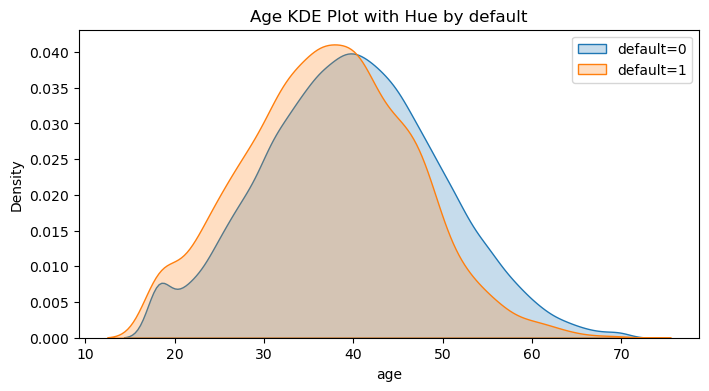

In [138]:
plt.figure(figsize=(8, 4))
sns.kdeplot(data_train_1['age'][data_train_1['default'] == 0], fill=True, label='default=0')
sns.kdeplot(data_train_1['age'][data_train_1['default'] == 1], fill=True, label='default=1')
plt.title(f"Age KDE Plot with Hue by default")
plt.legend()
plt.show()

**Insights**

1. Orange (defaulted) group is slightly shifted to left indicating that younger folks are more likely to default on their loans

**KDE for all the Columns**

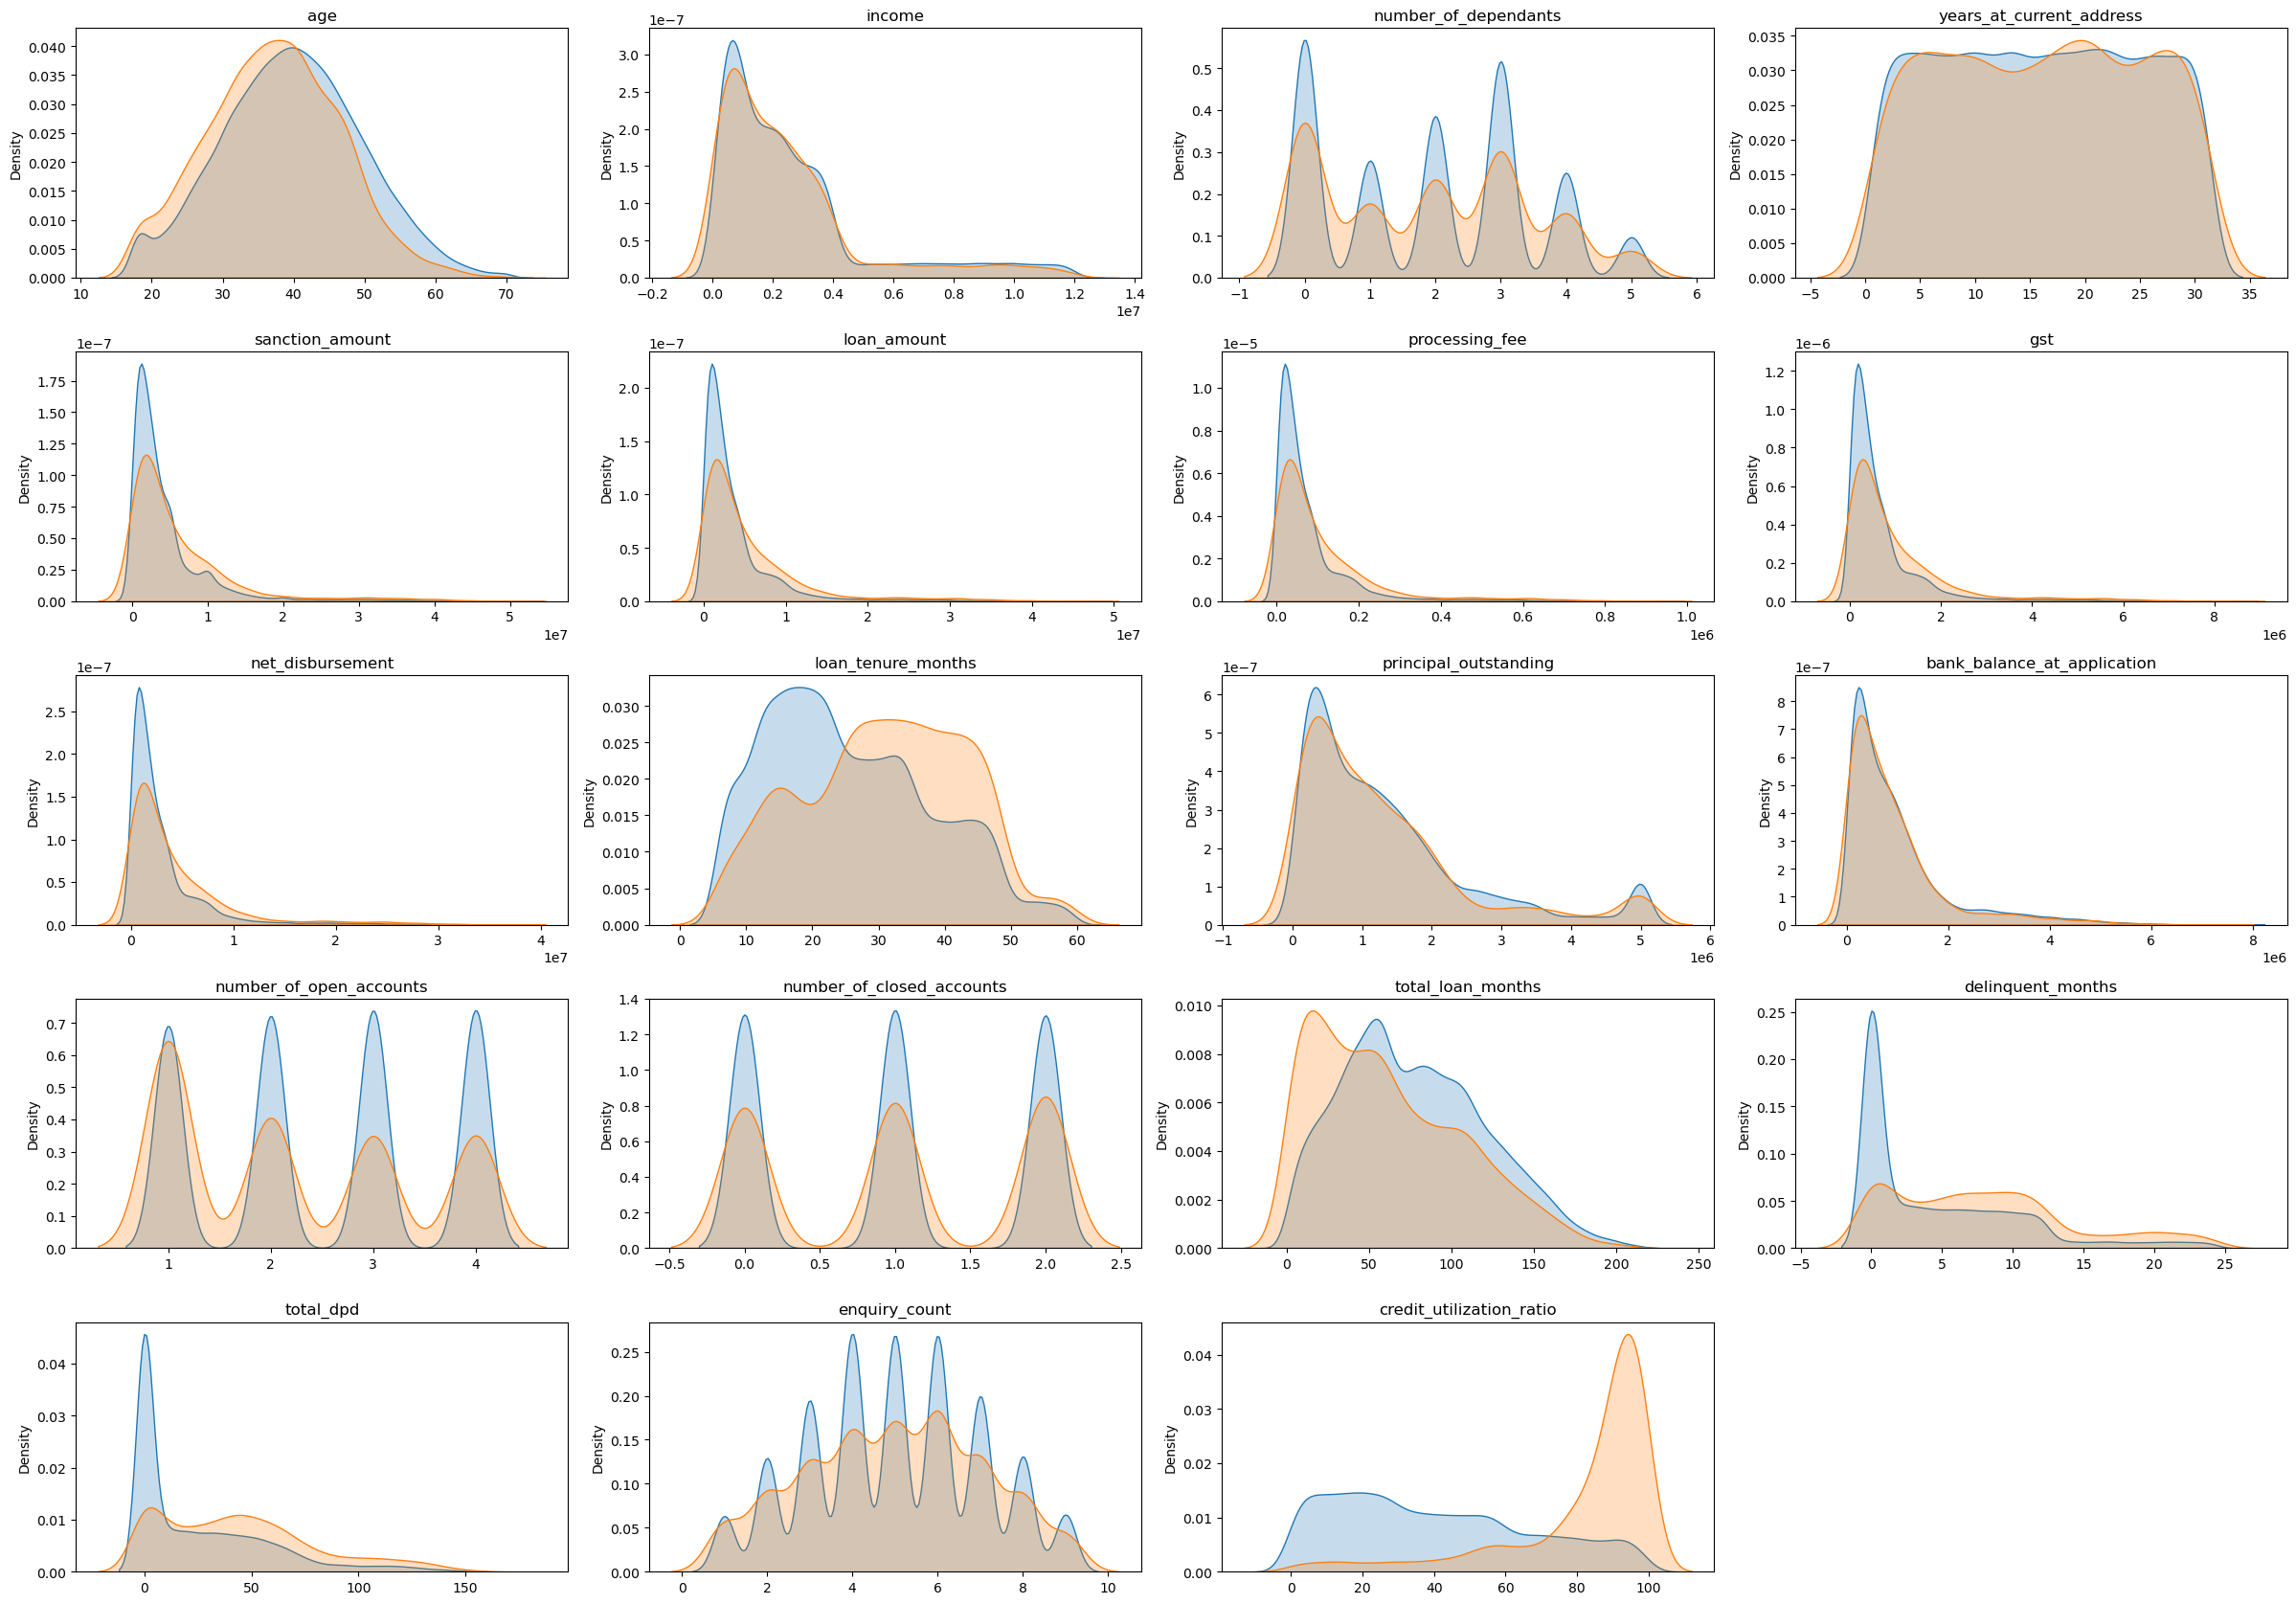

In [139]:
plt.figure(figsize=(24, 20))  # Width, height in inches

for i, col in enumerate(columns_continuous):
    plt.subplot(6, 4, i+1)  # 1 row, 4 columns, ith subplot
    sns.kdeplot(data_train_1[col][data_train_1['default']==0], fill=True, label='default=0')
    sns.kdeplot(data_train_1[col][data_train_1['default']==1], fill=True, label='default=1')
    plt.title(col)        
    plt.xlabel('')
    
plt.tight_layout()
plt.show()

**Insights**

1. In columns: loan_tenure_months, delinquent_months, total_dpd, credit_utilization, higher values indicate high likelyhood of becoming a default. Hence these 4 looks like strong predictors
1. In remaining columns the distributions do not give any obvious insights
1. Why loan_amount and income did not give any signs of being strong predictors? May be when we combine these two and get loan to income ratio (LTI), that may have influence on the target variable. We will explore more later

<h3 style="color:blue" align="center">Feature Engineering, Feature Selection</h3>

#### Generate Loan to Income (LTI) Ratio

In [140]:
data_train_1["loan_to_income"] = round(data_train_1["loan_amount"] / data_train_1["income"], 2)
data_train_1["loan_to_income"].describe()

count   37488.00
mean        1.56
std         0.97
min         0.30
25%         0.77
50%         1.16
75%         2.46
max         4.57
Name: loan_to_income, dtype: float64

In [141]:
data_test["loan_to_income"] = round(data_test["loan_amount"] / data_test["income"], 2)

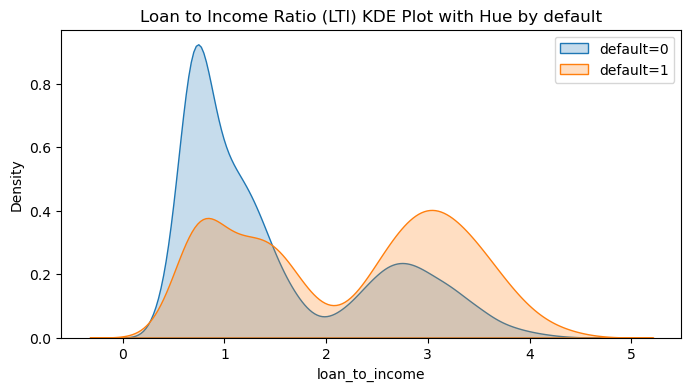

In [142]:
plt.figure(figsize=(8, 4))
sns.kdeplot(data_train_1['loan_to_income'][data_train_1['default'] == 0], fill=True, label='default=0')
sns.kdeplot(data_train_1['loan_to_income'][data_train_1['default'] == 1], fill=True, label='default=1')
plt.title(f"Loan to Income Ratio (LTI) KDE Plot with Hue by default")
plt.legend()
plt.show()

**Insights**
1. Blue graph has majority of its values on lower side of LTI
2. Orange graph has many values when LTI is higher indicating that higher LTI means high risk loan

#### Generate Delinquency Ratio

In [143]:
data_train_1["delinquency_ratio"] = (data_train_1["delinquent_months"] * 100 / data_train_1["total_loan_months"]).round(1)
data_test["delinquency_ratio"] = (data_test["delinquent_months"] * 100 / data_test["total_loan_months"]).round(1)

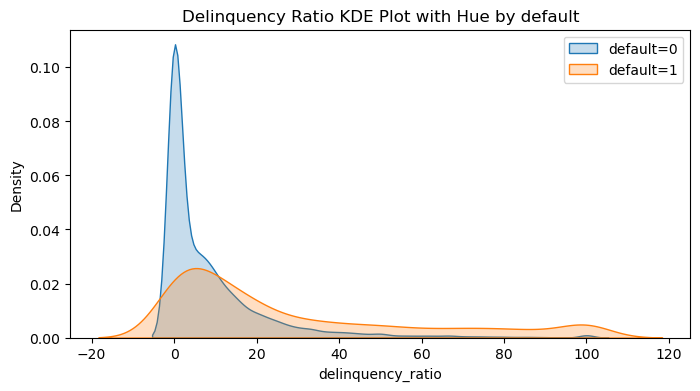

In [144]:
plt.figure(figsize=(8, 4))
sns.kdeplot(data_train_1['delinquency_ratio'][data_train_1['default'] == 0], fill=True, label='default=0')
sns.kdeplot(data_train_1['delinquency_ratio'][data_train_1['default'] == 1], fill=True, label='default=1')
plt.title(f"Delinquency Ratio KDE Plot with Hue by default")
plt.legend()
plt.show()

**Insights**
1. Blue graph has majority of its values on lower side of LTI
2. Orange graph has many values when delinquency ratio is higher indicating some correlation on default

#### Generate Avg DPD Per Delinquency

In [145]:
data_train_1["avg_dpd_per_delinquency"] = np.where(
    data_train_1["delinquent_months"] !=0,
    (data_train_1["total_dpd"] / data_train_1["delinquent_months"]).round(1),
    0
)

data_test['avg_dpd_per_delinquency'] = np.where(
    data_test['delinquent_months'] != 0,
    (data_test['total_dpd'] / data_test['delinquent_months']).round(1),
    0
)

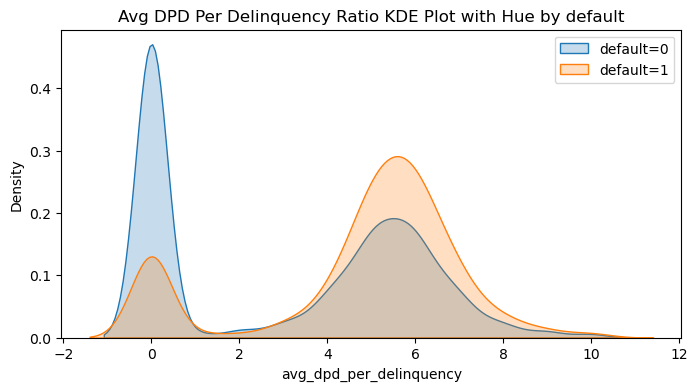

In [146]:
plt.figure(figsize=(8, 4))
sns.kdeplot(data_train_1['avg_dpd_per_delinquency'][data_train_1['default'] == 0], fill=True, label='default=0')
sns.kdeplot(data_train_1['avg_dpd_per_delinquency'][data_train_1['default'] == 1], fill=True, label='default=1')
plt.title(f"Avg DPD Per Delinquency Ratio KDE Plot with Hue by default")
plt.legend()
plt.show()

**Insights**

1. Graph clearly shows more occurances of default cases when avg_dpd_per_delinquency is high. This means this column is a strong predictor

**Remove columns that are just unique ids and don't have influence on target**

In [147]:
data_train_2 = data_train_1.drop(columns=['cust_id', 'loan_id'], axis="columns")
data_test = data_test.drop(columns=['cust_id', 'loan_id'], axis="columns")

**Remove columns that business contact person asked us to remove**

In [148]:
data_train_3 = data_train_2.drop(columns=['disbursal_date', 'installment_start_dt', 'loan_amount', 'income', 
                              'total_loan_months', 'delinquent_months', 'total_dpd'], axis="columns")

data_test = data_test.drop(columns=['disbursal_date', 'installment_start_dt', 'loan_amount', 'income', 
                              'total_loan_months', 'delinquent_months', 'total_dpd'], axis="columns")

data_train_3.columns

Index(['age', 'gender', 'marital_status', 'employment_status',
       'number_of_dependants', 'residence_type', 'years_at_current_address',
       'city', 'state', 'zipcode', 'loan_purpose', 'loan_type',
       'sanction_amount', 'processing_fee', 'gst', 'net_disbursement',
       'loan_tenure_months', 'principal_outstanding',
       'bank_balance_at_application', 'number_of_open_accounts',
       'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'default', 'loan_to_income',
       'delinquency_ratio', 'avg_dpd_per_delinquency'],
      dtype='object')

### VIF to measure multicolinearity

In [149]:
X_train= data_train_3.drop("default", axis="columns")
y_train = data_train_3["default"]

cols_to_scale = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = MinMaxScaler()

X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

X_train.describe()


,age,number_of_dependants,years_at_current_address,zipcode,sanction_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,number_of_open_accounts,number_of_closed_accounts,enquiry_count,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency
count,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00
mean,0.41,0.39,0.50,0.52,0.09,0.08,0.08,0.08,0.38,0.26,0.12,0.50,0.50,0.50,0.44,0.29,0.10,0.33
std,0.19,0.31,0.30,0.29,0.12,0.11,0.11,0.11,0.23,0.24,0.13,0.37,0.41,0.25,0.30,0.23,0.17,0.29
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.29,0.00,0.23,0.33,0.02,0.02,0.02,0.02,0.19,0.08,0.03,0.00,0.00,0.38,0.18,0.11,0.00,0.00
50%,0.40,0.40,0.50,0.49,0.05,0.05,0.05,0.05,0.34,0.19,0.08,0.67,0.50,0.50,0.39,0.20,0.04,0.43
75%,0.54,0.60,0.77,0.76,0.10,0.10,0.10,0.10,0.55,0.35,0.16,1.00,1.00,0.62,0.68,0.51,0.13,0.57
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


**Same transformation on test set**

In [150]:
X_test = data_test.drop("default", axis="columns")
y_test = data_test["default"]

X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

X_test.describe()

,age,number_of_dependants,years_at_current_address,zipcode,sanction_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,number_of_open_accounts,number_of_closed_accounts,enquiry_count,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency
count,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00
mean,0.42,0.38,0.50,0.53,0.09,0.08,0.08,0.08,0.38,0.26,0.12,0.50,0.50,0.50,0.44,0.29,0.11,0.33
std,0.19,0.31,0.30,0.29,0.12,0.11,0.11,0.11,0.23,0.25,0.13,0.37,0.41,0.25,0.30,0.23,0.17,0.29
min,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.29,0.00,0.23,0.33,0.02,0.02,0.02,0.02,0.19,0.08,0.03,0.00,0.00,0.38,0.18,0.11,0.00,0.00
50%,0.42,0.40,0.50,0.51,0.05,0.05,0.05,0.05,0.34,0.20,0.08,0.33,0.50,0.50,0.39,0.20,0.04,0.44
75%,0.54,0.60,0.77,0.76,0.10,0.09,0.09,0.09,0.55,0.36,0.16,0.67,1.00,0.62,0.68,0.50,0.13,0.58
max,1.00,1.00,1.00,1.00,0.98,0.96,0.96,0.96,1.00,1.00,0.94,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [151]:
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df["Columns"] = data.columns
    vif_df["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

calculate_vif(X_train[cols_to_scale])

c:\Users\rohit\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Columns,VIF
0,age,5.70
1,number_of_dependants,2.73
2,years_at_current_address,3.42
3,zipcode,3.80
4,sanction_amount,101.09
5,processing_fee,inf
6,gst,inf
7,net_disbursement,inf
8,loan_tenure_months,6.18
9,principal_outstanding,16.33


In [152]:
features_to_drop_vif = ['sanction_amount', 'processing_fee', 'gst', 'net_disbursement','principal_outstanding']

X_train1 = X_train.drop(features_to_drop_vif, axis="columns")

numeric_columns = X_train1.select_dtypes(include=['int64', 'float64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'years_at_current_address', 'zipcode',
       'loan_tenure_months', 'bank_balance_at_application',
       'number_of_open_accounts', 'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency'],
      dtype='object')

In [153]:
vif_df = calculate_vif(X_train1[numeric_columns])
vif_df

,Columns,VIF
0,age,5.43
1,number_of_dependants,2.73
2,years_at_current_address,3.40
3,zipcode,3.78
4,loan_tenure_months,6.02
5,bank_balance_at_application,1.80
6,number_of_open_accounts,4.35
7,number_of_closed_accounts,2.37
8,enquiry_count,6.38
9,credit_utilization_ratio,2.92


In [154]:
selected_numeric_features_vif = vif_df.Columns.values
selected_numeric_features_vif

array(['age', 'number_of_dependants', 'years_at_current_address',
       'zipcode', 'loan_tenure_months', 'bank_balance_at_application',
       'number_of_open_accounts', 'number_of_closed_accounts',
       'enquiry_count', 'credit_utilization_ratio', 'loan_to_income',
       'delinquency_ratio', 'avg_dpd_per_delinquency'], dtype=object)

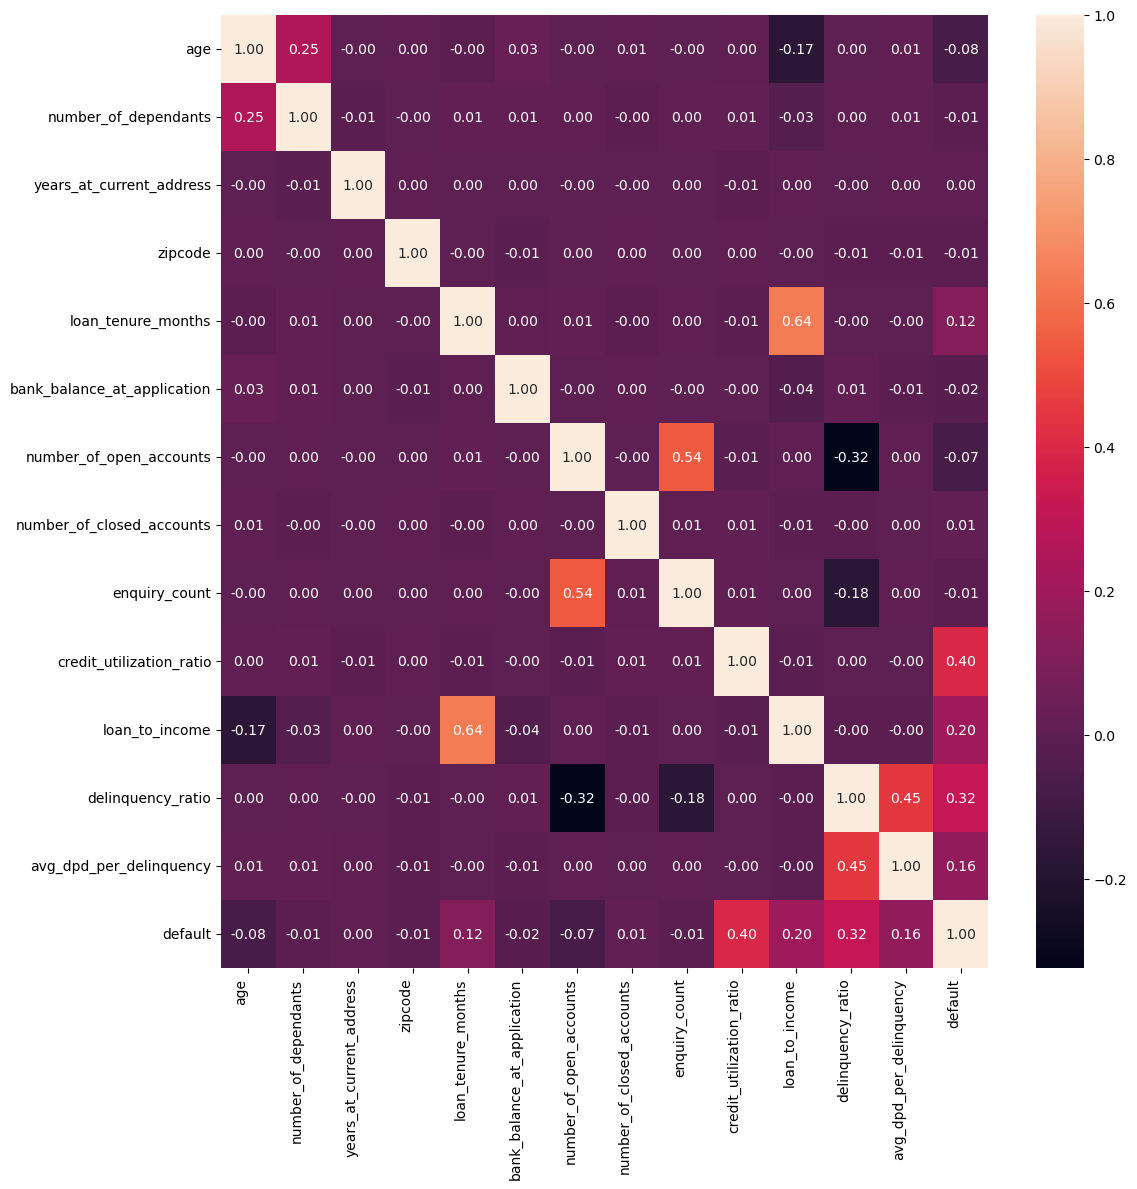

In [155]:
plt.figure(figsize=(12,12))
cm = data_train_3[numeric_columns.append(pd.Index(['default']))].corr()
sns.heatmap(cm, annot=True, fmt='0.2f')
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Feature Selection: Categorical Features

In [156]:
X_train1.head(3)

,age,gender,marital_status,employment_status,number_of_dependants,residence_type,years_at_current_address,city,state,zipcode,loan_purpose,loan_type,loan_tenure_months,bank_balance_at_application,number_of_open_accounts,number_of_closed_accounts,enquiry_count,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency
12746,0.79,M,Married,Self-Employed,0.60,Owned,0.97,Hyderabad,Telangana,0.66,Home,Secured,0.42,0.61,1.00,1.00,0.38,0.36,0.41,0.13,0.59
32495,0.50,F,Single,Salaried,0.00,Owned,0.87,Mumbai,Maharashtra,0.49,Education,Secured,0.83,0.03,0.67,0.50,0.50,0.05,0.31,0.06,0.62
43675,0.38,M,Single,Salaried,0.00,Mortgage,0.83,Chennai,Tamil Nadu,0.83,Home,Secured,0.49,0.17,0.00,0.50,0.38,0.00,0.76,0.22,0.56


### Calculate WOE and IV

In [159]:
def calculate_woe_iv(df, feature, target):
    grouped = df.groupby(feature)[target].agg(['count','sum'])
    grouped = grouped.rename(columns={'count': 'total', 'sum': 'good'})
    grouped['bad']=grouped['total']-grouped['good']
    
    total_good = grouped['good'].sum()
    total_bad = grouped['bad'].sum()
    
    grouped['good_pct'] = grouped['good'] / total_good
    grouped['bad_pct'] = grouped['bad'] / total_bad
    grouped['woe'] = np.log(grouped['good_pct']/ grouped['bad_pct'])
    grouped['iv'] = (grouped['good_pct'] -grouped['bad_pct'])*grouped['woe']
    
    grouped['woe'] = grouped['woe'].replace([np.inf, -np.inf], 0)
    grouped['iv'] = grouped['iv'].replace([np.inf, -np.inf], 0)
    
    total_iv = grouped['iv'].sum()
    
    return grouped, total_iv


grouped, total_iv = calculate_woe_iv(pd.concat([X_train1, y_train], axis=1), 'loan_purpose', 'default')
grouped

,total,good,bad,good_pct,bad_pct,woe,iv
loan_purpose,,,,,,,
Auto,7447,327,7120,0.10,0.21,-0.72,0.08
Education,5620,559,5061,0.17,0.15,0.16,0.00
Home,11304,1734,9570,0.54,0.28,0.66,0.17
Personal,13117,603,12514,0.19,0.37,-0.67,0.12


In [160]:
iv_values = {}

for each_col in X_train1.columns:
    if X_train1[each_col].dtype == 'object':
        _, iv = calculate_woe_iv(pd.concat([X_train1, y_train], axis=1), each_col, 'default')
    else:
        X_binned = pd.cut(X_train1[each_col], bins=10, labels=False)
        _, iv = calculate_woe_iv(pd.concat([X_binned, y_train], axis=1), each_col, 'default')
    iv_values[each_col] = iv
    


iv_values

{'age': 0.0890689462679479,
 'gender': 0.00047449502170914947,
 'marital_status': 0.001129766845390142,
 'employment_status': 0.003953046301722585,
 'number_of_dependants': 0.0019380899135053508,
 'residence_type': 0.246745268718145,
 'years_at_current_address': 0.0020800513608156363,
 'city': 0.0019059578709781529,
 'state': 0.0019005589806779287,
 'zipcode': 0.0016677413243392572,
 'loan_purpose': 0.3691197842282755,
 'loan_type': 0.16319324904149224,
 'loan_tenure_months': 0.21893515090196278,
 'bank_balance_at_application': 0.0063187993277516365,
 'number_of_open_accounts': 0.08463134083005877,
 'number_of_closed_accounts': 0.0011964272592421567,
 'enquiry_count': 0.007864214085342608,
 'credit_utilization_ratio': 2.352965568168245,
 'loan_to_income': 0.476415456948364,
 'delinquency_ratio': 0.716576108689321,
 'avg_dpd_per_delinquency': 0.40151905412190175}

In [163]:
iv_df = pd.DataFrame(list(iv_values.items()), columns=['Feature', 'IV'])
iv_df = iv_df.sort_values(by="IV", ascending=False)
iv_df

,Feature,IV
17,credit_utilization_ratio,2.353
19,delinquency_ratio,0.717
18,loan_to_income,0.476
20,avg_dpd_per_delinquency,0.402
10,loan_purpose,0.369
5,residence_type,0.247
12,loan_tenure_months,0.219
11,loan_type,0.163
0,age,0.089
14,number_of_open_accounts,0.085


In [164]:
select_features_iv = []

for feature, iv in iv_values.items():
    if iv > 0.02:
        select_features_iv.append(feature)

select_features_iv

['age',
 'residence_type',
 'loan_purpose',
 'loan_type',
 'loan_tenure_months',
 'number_of_open_accounts',
 'credit_utilization_ratio',
 'loan_to_income',
 'delinquency_ratio',
 'avg_dpd_per_delinquency']

### Feature Encoding

In [165]:
X_train_reduced = X_train1[select_features_iv]
X_test_reduced = X_test[select_features_iv]

X_train_reduced.head(3)

,age,residence_type,loan_purpose,loan_type,loan_tenure_months,number_of_open_accounts,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency
12746,0.788,Owned,Home,Secured,0.415,1.000,0.364,0.415,0.132,0.590
32495,0.500,Owned,Education,Secured,0.830,0.667,0.051,0.307,0.062,0.620
43675,0.385,Mortgage,Home,Secured,0.491,0.000,0.000,0.759,0.222,0.560


In [166]:
X_train_encoded = pd.get_dummies(X_train_reduced, drop_first=True)
X_test_encoded = pd.get_dummies(X_test_reduced, drop_first=True)

X_train_encoded.head(3)

,age,loan_tenure_months,number_of_open_accounts,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency,residence_type_Owned,residence_type_Rented,loan_purpose_Education,loan_purpose_Home,loan_purpose_Personal,loan_type_Unsecured
12746,0.788,0.415,1.000,0.364,0.415,0.132,0.590,True,False,False,True,False,False
32495,0.500,0.830,0.667,0.051,0.307,0.062,0.620,True,False,True,False,False,False
43675,0.385,0.491,0.000,0.000,0.759,0.222,0.560,False,False,False,True,False,False


<h3 align="center" style="color:blue">Model Training</h3>

### Attempt 1

1. Logistic Regression, RandomForest & XGB
1. No handling of class imbalance

In [172]:
model = LogisticRegression()
model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(f"{report}")

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     11423
           1       0.84      0.72      0.78      1074

    accuracy                           0.96     12497
   macro avg       0.91      0.85      0.88     12497
weighted avg       0.96      0.96      0.96     12497



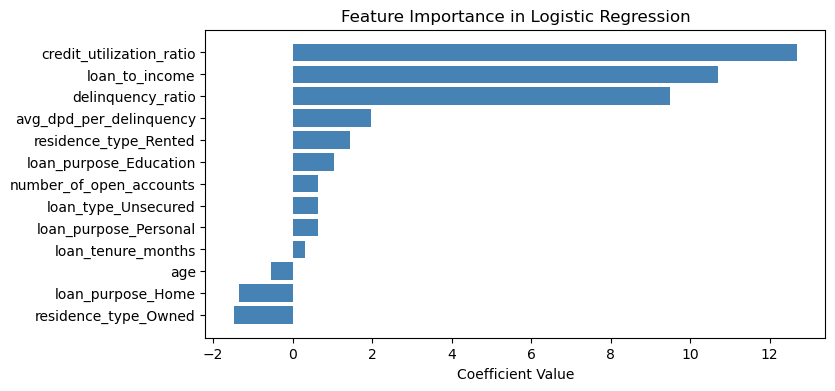

In [178]:
feature_importance = model.coef_[0]

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train_encoded.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Logistic Regression')
plt.show()

In [170]:
model = RandomForestClassifier()
model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(f"{report}")

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     11423
           1       0.85      0.71      0.78      1074

    accuracy                           0.96     12497
   macro avg       0.91      0.85      0.88     12497
weighted avg       0.96      0.96      0.96     12497



In [171]:
model = XGBClassifier()
model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(f"{report}")

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11423
           1       0.82      0.76      0.79      1074

    accuracy                           0.96     12497
   macro avg       0.90      0.87      0.88     12497
weighted avg       0.96      0.96      0.96     12497



- Since there is not much difference between XGB and Logistic, we will choose LogisticRegression as a candidate for our RandomizedSearchCV candidate it has a better interpretation.

#### RandomizedSearch CV for Attempt 1: Logistic Regression

In [181]:
param_dist = {
    'C': np.logspace(-4, 4, 20),  # Logarithmically spaced values from 10^-4 to 10^4
    'solver': ['lbfgs', 'saga', 'liblinear', 'newton-cg']   # Algorithm to use in the optimization problem
}

# Create the Logistic Regression model
log_reg = LogisticRegression(max_iter=10000)  # Increased max_iter for convergence

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='f1',
    cv=3,  # 5-fold cross-validation
    verbose=2,
    random_state=42,  # Set a random state for reproducibility
    n_jobs=-1  # Use all available cores
)

# Fit the RandomizedSearchCV to the training data
random_search.fit(X_train_encoded, y_train)

# Print the best parameters and best score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_encoded)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'solver': 'liblinear', 'C': 1438.44988828766}
Best Score: 0.7578820896729831
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     11423
           1       0.83      0.74      0.78      1074

    accuracy                           0.96     12497
   macro avg       0.90      0.86      0.88     12497
weighted avg       0.96      0.96      0.96     12497



#### RandomizedSearch CV for Attempt 1: XGBoost

In [182]:
# Define parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'scale_pos_weight': [1, 2, 3, 5, 7, 10],
    'reg_alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],  # L1 regularization term
    'reg_lambda': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]  # L2 regularization term
}

xgb = XGBClassifier()

random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=100,
                                   scoring='f1', cv=3, verbose=1, n_jobs=-1, random_state=42)

random_search.fit(X_train_encoded, y_train)

# Print the best parameters and best score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_encoded)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'subsample': 0.9, 'scale_pos_weight': 2, 'reg_lambda': 10.0, 'reg_alpha': 10.0, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Best Score: 0.7897950086476456
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11423
           1       0.78      0.82      0.80      1074

    accuracy                           0.96     12497
   macro avg       0.88      0.90      0.89     12497
weighted avg       0.97      0.96      0.96     12497



### Attempt 2

1. Logistic Regression & XGB
1. Handle Class Imbalance Using Under Sampling

In [183]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_encoded, y_train)

y_train_rus.value_counts()

default
0    3223
1    3223
Name: count, dtype: int64

In [184]:
model = LogisticRegression()
model.fit(X_train_rus, y_train_rus)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(f"{report}")

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     11423
           1       0.51      0.96      0.67      1074

    accuracy                           0.92     12497
   macro avg       0.75      0.93      0.81     12497
weighted avg       0.95      0.92      0.93     12497



In [186]:
model = XGBClassifier(**random_search.best_params_)
model.fit(X_train_rus, y_train_rus)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(f"{report}")

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     11423
           1       0.52      0.99      0.68      1074

    accuracy                           0.92     12497
   macro avg       0.76      0.95      0.82     12497
weighted avg       0.96      0.92      0.93     12497



### Attempt 3

1. Logistic Regression
1. Handle Class Imbalance Using SMOTE Tomek
1. Parameter tunning using optuna

In [187]:
smt = SMOTETomek(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train_encoded, y_train)

y_train_smt.value_counts()

default
0    34195
1    34195
Name: count, dtype: int64

In [188]:
model = LogisticRegression()
model.fit(X_train_smt, y_train_smt)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(f"{report}")

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     11423
           1       0.55      0.94      0.70      1074

    accuracy                           0.93     12497
   macro avg       0.77      0.94      0.83     12497
weighted avg       0.96      0.93      0.94     12497



In [189]:
model = XGBClassifier(**random_search.best_params_)
model.fit(X_train_smt, y_train_smt)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(f"{report}")

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     11423
           1       0.69      0.89      0.78      1074

    accuracy                           0.96     12497
   macro avg       0.84      0.92      0.88     12497
weighted avg       0.96      0.96      0.96     12497



In [190]:
# Define the objective function for Optuna
def objective(trial):
    
    param = {
        'C': trial.suggest_float('C', 1e-4, 1e4, log=True),  # Logarithmically spaced values
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga', 'newton-cg']),  # Solvers
        'tol': trial.suggest_float('tol', 1e-6, 1e-1, log=True),  # Logarithmically spaced values for tolerance
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])  # Class weights
    }

    model = LogisticRegression(**param, max_iter=10000)

    # Calculate the cross-validated f1_score
    f1_scorer = make_scorer(f1_score, average="macro")
    scores = cross_val_score(model, X_train_smt, y_train_smt, cv=3, scoring=f1_scorer, n_jobs=-1)

    return np.mean(scores)

study_logistic = optuna.create_study(direction = "maximize")
study_logistic.optimize(objective, n_trials=50)

[I 2024-12-11 08:49:42,057] A new study created in memory with name: no-name-379a472d-55cc-46a0-8055-0a74e5fdfcdb
[I 2024-12-11 08:49:46,366] Trial 0 finished with value: 0.9457665622389632 and parameters: {'C': 7.0589548516797045, 'solver': 'newton-cg', 'tol': 0.005091777447786185, 'class_weight': None}. Best is trial 0 with value: 0.9457665622389632.
[I 2024-12-11 08:49:50,202] Trial 1 finished with value: 0.9456354945573398 and parameters: {'C': 105.89470445020655, 'solver': 'saga', 'tol': 1.807651777051766e-05, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9457665622389632.
[I 2024-12-11 08:49:52,645] Trial 2 finished with value: 0.8378307034531388 and parameters: {'C': 0.00016521096419693407, 'solver': 'lbfgs', 'tol': 2.7956824842096353e-06, 'class_weight': None}. Best is trial 0 with value: 0.9457665622389632.
[I 2024-12-11 08:49:52,974] Trial 3 finished with value: 0.9363898364057311 and parameters: {'C': 0.030165450728509267, 'solver': 'lbfgs', 'tol': 2.96080545822

In [195]:
print("Best Trial : ")
trial = study_logistic.best_trial

print("F1-score: {}".format(trial.value))

print(" Params :")
for key, value in trial.params.items():
    print(f" {key} ==> {value} ")

best_model_logistic = LogisticRegression(**study_logistic.best_params)
best_model_logistic.fit(X_train_smt, y_train_smt)

y_pred = best_model_logistic.predict(X_test_encoded)

report = classification_report(y_test, y_pred)
print(report)

Best Trial : 
F1-score: 0.9458391870989961
 Params :
 C ==> 3.9364332257405463 
 solver ==> newton-cg 
 tol ==> 0.000996923784564128 
 class_weight ==> None 
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     11423
           1       0.56      0.94      0.70      1074

    accuracy                           0.93     12497
   macro avg       0.78      0.94      0.83     12497
weighted avg       0.96      0.93      0.94     12497



### Attempt 4

1. XGBoost
1. Handle Class Imbalance Using SMOTE Tomek
1. Parameter tunning using optuna

In [196]:
# Define the objective function for Optuna
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'verbosity': 0,
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10)
    }

    model = XGBClassifier(**param)
    
    # Calculate the cross-validated f1_score
    f1_scorer = make_scorer(f1_score, average='macro')
    scores = cross_val_score(model, X_train_smt, y_train_smt, cv=3, scoring=f1_scorer, n_jobs=-1)
    
    return np.mean(scores)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective, n_trials=50)

[I 2024-12-11 08:59:51,237] A new study created in memory with name: no-name-ea334f2e-1bbb-4683-a88d-ec67ca816ba2
[I 2024-12-11 08:59:58,996] Trial 0 finished with value: 0.9723657158558834 and parameters: {'lambda': 0.08564929693176825, 'alpha': 1.618276206093448, 'subsample': 0.9206242242184635, 'colsample_bytree': 0.6516368146195433, 'max_depth': 9, 'eta': 0.12981461649960768, 'gamma': 1.4604224416860123, 'scale_pos_weight': 2.4092906253726896, 'min_child_weight': 7, 'max_delta_step': 10}. Best is trial 0 with value: 0.9723657158558834.
[I 2024-12-11 09:00:03,335] Trial 1 finished with value: 0.958059450994762 and parameters: {'lambda': 0.19826022131573956, 'alpha': 0.0015318490254081776, 'subsample': 0.995893463064879, 'colsample_bytree': 0.5365367071596563, 'max_depth': 6, 'eta': 0.11181858587867836, 'gamma': 7.851232084707435, 'scale_pos_weight': 3.1933193263438366, 'min_child_weight': 2, 'max_delta_step': 3}. Best is trial 0 with value: 0.9723657158558834.
[I 2024-12-11 09:00:07

In [197]:
print('Best trial:')
trial = study_xgb.best_trial
print('  F1-score: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))
    
best_params = study_xgb.best_params
best_model_xgb = XGBClassifier(**best_params)
best_model_xgb.fit(X_train_smt, y_train_smt)

# Evaluate on the test set
y_pred = best_model_xgb.predict(X_test_encoded)

report = classification_report(y_test, y_pred)
print(report)

Best trial:
  F1-score: 0.9763075942807168
  Params: 
    lambda: 0.15769088780561671
    alpha: 0.19719919947436743
    subsample: 0.5289413350220897
    colsample_bytree: 0.8818253497137578
    max_depth: 10
    eta: 0.21088930403305992
    gamma: 0.8386661353045879
    scale_pos_weight: 1.590805406630146
    min_child_weight: 3
    max_delta_step: 4
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     11423
           1       0.73      0.85      0.78      1074

    accuracy                           0.96     12497
   macro avg       0.86      0.91      0.88     12497
weighted avg       0.96      0.96      0.96     12497



## Model Evaluation : ROC/AUC

In [202]:
probabilities = best_model_logistic.predict_proba(X_test_encoded)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities)
fpr[:5], tpr[:5], thresholds[:5]

(array([0.        , 0.        , 0.        , 0.00008754, 0.00008754]),
 array([0.        , 0.0009311 , 0.16108007, 0.16108007, 0.17690875]),
 array([2.       , 1.       , 0.9994519, 0.9994511, 0.9993293]))

In [204]:
area = auc(fpr, tpr)
area

0.9836757360554054

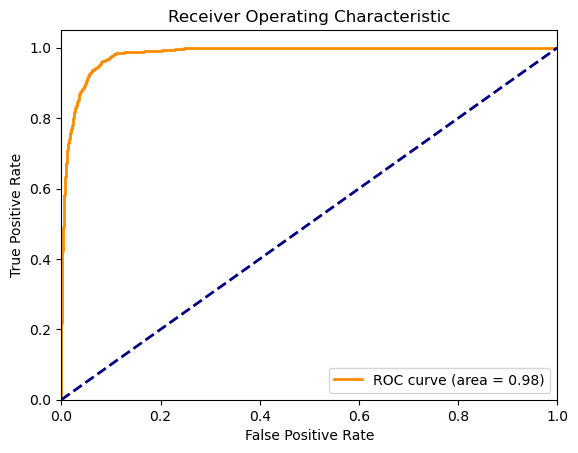

In [205]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Model Evaluation : Rankordering, KS statistic, Gini coeff

In [210]:
probabilities = best_model_logistic.predict_proba(X_test_encoded)[:, 1]

data_eval = pd.DataFrame({
    "Default Truth": y_test,
    "Default probabilities": probabilities
})

data_eval.head(3)

,Default Truth,Default probabilities
19205,0,0.532
15514,0,0.000
30367,0,0.006


In [213]:
data_eval["Decile"] = pd.qcut(data_eval["Default probabilities"], 10, labels=False, duplicates="drop")
data_eval.head(3)

,Default Truth,Default probabilities,Decile
19205,0,0.532,8
15514,0,0.000,2
30367,0,0.006,6


In [220]:
data_decile = data_eval.groupby('Decile').apply(lambda x: pd.Series({
    "Minimum Probability" : x["Default probabilities"].min(),
    "Maximum Probability" : x["Default probabilities"].max(),
    "Events" : x["Default Truth"].sum(),
    "Non-Events" : x["Default Truth"].count() - x["Default Truth"].sum(),
}))

data_decile.reset_index(inplace=True)
data_decile

C:\Users\rohit\AppData\Local\Temp\ipykernel_12852\2971897092.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_decile = data_eval.groupby('Decile').apply(lambda x: pd.Series({


,Decile,Minimum Probability,Maximum Probability,Events,Non-Events
0,0,0.000,0.000,0.000,1250.000
1,1,0.000,0.000,0.000,1250.000
2,2,0.000,0.000,0.000,1249.000
3,3,0.000,0.000,0.000,1250.000
4,4,0.000,0.001,0.000,1250.000
5,5,0.001,0.004,0.000,1249.000
6,6,0.004,0.029,5.000,1245.000
7,7,0.029,0.213,11.000,1238.000
8,8,0.213,0.819,159.000,1091.000
9,9,0.820,1.000,899.000,351.000


In [221]:
data_decile["Event Rate"] = data_decile["Events"] * 100 / (data_decile["Events"] + data_decile["Non-Events"])
data_decile["Non-Event Rate"] = data_decile["Non-Events"] * 100 / (data_decile["Events"] + data_decile["Non-Events"])

data_decile = data_decile.sort_values(by="Decile", ascending=False).reset_index(drop=True)
data_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-Events,Event Rate,Non-Event Rate
0,9,0.820,1.000,899.000,351.000,71.920,28.080
1,8,0.213,0.819,159.000,1091.000,12.720,87.280
2,7,0.029,0.213,11.000,1238.000,0.881,99.119
3,6,0.004,0.029,5.000,1245.000,0.400,99.600
4,5,0.001,0.004,0.000,1249.000,0.000,100.000
5,4,0.000,0.001,0.000,1250.000,0.000,100.000
6,3,0.000,0.000,0.000,1250.000,0.000,100.000
7,2,0.000,0.000,0.000,1249.000,0.000,100.000
8,1,0.000,0.000,0.000,1250.000,0.000,100.000
9,0,0.000,0.000,0.000,1250.000,0.000,100.000


In [223]:
data_decile["Cum Events"] = data_decile["Events"].cumsum()
data_decile["Cum Non-Events"] = data_decile["Non-Events"].cumsum()

data_decile["Cum Event Rate"] = data_decile["Cum Events"] * 100 / data_decile["Events"].sum()
data_decile["Cum Non-Event Rate"] = data_decile["Cum Non-Events"] * 100 / data_decile["Non-Events"].sum()

data_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-Events,Event Rate,Non-Event Rate,Cum Events,Cum Non-Events,Cum Event Rate,Cum Non-Event Rate
0,9,0.820,1.000,899.000,351.000,71.920,28.080,899.000,351.000,83.706,3.073
1,8,0.213,0.819,159.000,1091.000,12.720,87.280,1058.000,1442.000,98.510,12.624
2,7,0.029,0.213,11.000,1238.000,0.881,99.119,1069.000,2680.000,99.534,23.461
3,6,0.004,0.029,5.000,1245.000,0.400,99.600,1074.000,3925.000,100.000,34.361
4,5,0.001,0.004,0.000,1249.000,0.000,100.000,1074.000,5174.000,100.000,45.295
5,4,0.000,0.001,0.000,1250.000,0.000,100.000,1074.000,6424.000,100.000,56.237
6,3,0.000,0.000,0.000,1250.000,0.000,100.000,1074.000,7674.000,100.000,67.180
7,2,0.000,0.000,0.000,1249.000,0.000,100.000,1074.000,8923.000,100.000,78.114
8,1,0.000,0.000,0.000,1250.000,0.000,100.000,1074.000,10173.000,100.000,89.057
9,0,0.000,0.000,0.000,1250.000,0.000,100.000,1074.000,11423.000,100.000,100.000


In [224]:
data_decile["KS"] = abs(data_decile["Cum Event Rate"] - data_decile["Cum Non-Event Rate"])
data_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-Events,Event Rate,Non-Event Rate,Cum Events,Cum Non-Events,Cum Event Rate,Cum Non-Event Rate,KS
0,9,0.820,1.000,899.000,351.000,71.920,28.080,899.000,351.000,83.706,3.073,80.633
1,8,0.213,0.819,159.000,1091.000,12.720,87.280,1058.000,1442.000,98.510,12.624,85.887
2,7,0.029,0.213,11.000,1238.000,0.881,99.119,1069.000,2680.000,99.534,23.461,76.073
3,6,0.004,0.029,5.000,1245.000,0.400,99.600,1074.000,3925.000,100.000,34.361,65.639
4,5,0.001,0.004,0.000,1249.000,0.000,100.000,1074.000,5174.000,100.000,45.295,54.705
5,4,0.000,0.001,0.000,1250.000,0.000,100.000,1074.000,6424.000,100.000,56.237,43.763
6,3,0.000,0.000,0.000,1250.000,0.000,100.000,1074.000,7674.000,100.000,67.180,32.820
7,2,0.000,0.000,0.000,1249.000,0.000,100.000,1074.000,8923.000,100.000,78.114,21.886
8,1,0.000,0.000,0.000,1250.000,0.000,100.000,1074.000,10173.000,100.000,89.057,10.943
9,0,0.000,0.000,0.000,1250.000,0.000,100.000,1074.000,11423.000,100.000,100.000,0.000


To assess whether rank ordering is followed, we should look at whether higher deciles (those with higher predicted probabilities) have higher event rates compared to lower deciles. Rank ordering means that as you move from the top decile to the bottom decile, the event rate should generally decrease.

Non-Events - termed as good (customers) who do not default. Events - termed as bad (customers) who default.

Events and Non-Events terms are interchanged based on usecase to usecase.

eg: for marketing usecase, which customer to reach out (who will take loan based on offers) will be events - here it will termed as good, and the customers who will not take loans will be non-events (bad).

**Insights from the Decile Table**

1. Top Deciles

* The first decile (Decile 9) has a high event rate of 72.00% and a non-event rate of 28.00%. This indicates that the model is highly confident in predicting events in this decile.
* The second decile (Decile 8) also shows a significant event rate of 12.72%, with a cumulative event rate reaching 98.6%.

2. Middle Deciles:

* Deciles 7 and 6 show a significant drop in event rates

3. Lower Deciles:

* Deciles 5 to 0 show zero events, with all predictions being non-events. These deciles collectively have a non-event rate of 100%.

4. KS Statistic:

* The KS statistic, which is the maximum difference between cumulative event rates and cumulative non-event rates, is highest at Decile 8 with a value of 85.98%. This suggests that the model performs best at distinguishing between events and non-events up to this decile.

* The KS value gradually decreases in the following deciles, indicating a decrease in model performance for distinguishing between events and non-events.

**KS Value**

The highest KS value is 85.98%, found at Decile 8. This indicates that the model's performance in distinguishing between events and non-events is most significant at this decile. (If KS is in top 3 decile and score above 40, it is considered a good predictive model.)

In [225]:
gini_coefficient = 2 * area - 1

print("AUC:", area)
print("Gini Coefficient:", gini_coefficient)

AUC: 0.9836757360554054
Gini Coefficient: 0.9673514721108107


- AUC of 0.98: The model is very good at distinguishing between events and non-events.

- Gini coefficient of 0.96: This further confirms that the model is highly effective in its predictions, with almost perfect rank ordering capability.

- The Gini coefficient ranges from -1 to 1, where a value closer to 1 signifies a perfect model, 0 indicates a model with no discriminative power, and -1 signifies a perfectly incorrect model.

#### Finalize The Model and Visualize Feature Importance

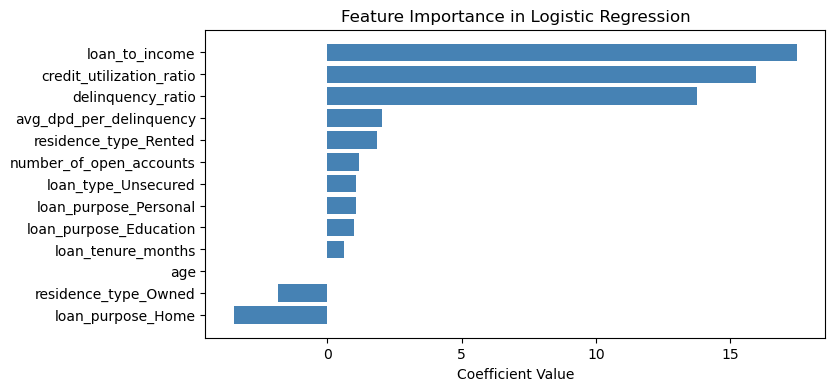

In [227]:
final_model = best_model_logistic

feature_importance = final_model.coef_[0]

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train_encoded.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Logistic Regression')
plt.show()

### Save the Model

In [228]:
X_test_encoded.head(2)

,age,loan_tenure_months,number_of_open_accounts,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency,residence_type_Owned,residence_type_Rented,loan_purpose_Education,loan_purpose_Home,loan_purpose_Personal,loan_type_Unsecured
19205,0.346,0.755,0.333,0.990,0.550,0.000,0.000,True,False,False,True,False,False
15514,0.481,0.226,1.000,0.323,0.220,0.000,0.000,True,False,True,False,False,False


In [229]:
X_test_encoded.columns

Index(['age', 'loan_tenure_months', 'number_of_open_accounts',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency', 'residence_type_Owned',
       'residence_type_Rented', 'loan_purpose_Education', 'loan_purpose_Home',
       'loan_purpose_Personal', 'loan_type_Unsecured'],
      dtype='object')

In [230]:
cols_to_scale

Index(['age', 'number_of_dependants', 'years_at_current_address', 'zipcode',
       'sanction_amount', 'processing_fee', 'gst', 'net_disbursement',
       'loan_tenure_months', 'principal_outstanding',
       'bank_balance_at_application', 'number_of_open_accounts',
       'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency'],
      dtype='object')

In [231]:
X_train_encoded.columns

Index(['age', 'loan_tenure_months', 'number_of_open_accounts',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency', 'residence_type_Owned',
       'residence_type_Rented', 'loan_purpose_Education', 'loan_purpose_Home',
       'loan_purpose_Personal', 'loan_type_Unsecured'],
      dtype='object')

In [236]:
model_data = {
    'model': final_model,
    'features': X_train_encoded.columns,
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}
dump(model_data, r'D:\ML\Classification\Credit_Risk_Modelling\artifacts\model_data.joblib')

['D:\\ML\\Classification\\Credit_Risk_Modelling\\artifacts\\model_data.joblib']

In [237]:
final_model.coef_, final_model.intercept_

(array([[ 0.00299696,  0.63465298,  1.18318467, 15.977536  , 17.501316  ,
         13.76018905,  2.04955693, -1.8432979 ,  1.85502584,  1.00399866,
         -3.48924626,  1.06251627,  1.06251627]]),
 array([-20.86223213]))